In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sea
import random
import tensorflow as tf
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import svm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from IPython.display import display
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn import svm
from IPython.display import clear_output


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
# load pretrained MobileNet
pre_trained_model = MobileNet(input_shape=(224,224,3), include_top=True)
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [5]:
vector = pre_trained_model.get_layer("reshape_2").output
feature_extractor = tf.keras.Model(pre_trained_model.input, vector)

In [6]:
labels = ['bellflower','daisy','dandelion','tulip','sunflower','rose','lotus','iris']
path = "D:/STUDY/CODE/ML/PredFlower/Data/flowers"

# create empty feature and label lists
x_list = []
y_list = []

for f in range(8):
    folder_path = os.path.join(path, labels[f])
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        # load image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))
        # convert image to numpy array
        img_arr = np.array(img)
        # add 1 more dimension
        img_arr_b = np.expand_dims(img_arr, axis=0)
        # preprocess image
        input_img = preprocess_input(img_arr_b)
        # extract feature
        feature_vec = feature_extractor.predict(input_img)
        x_list.append(feature_vec.ravel())
        y_list.append(f)
        clear_output(wait=True)

1/1 [==============================] - 1s 952ms/step


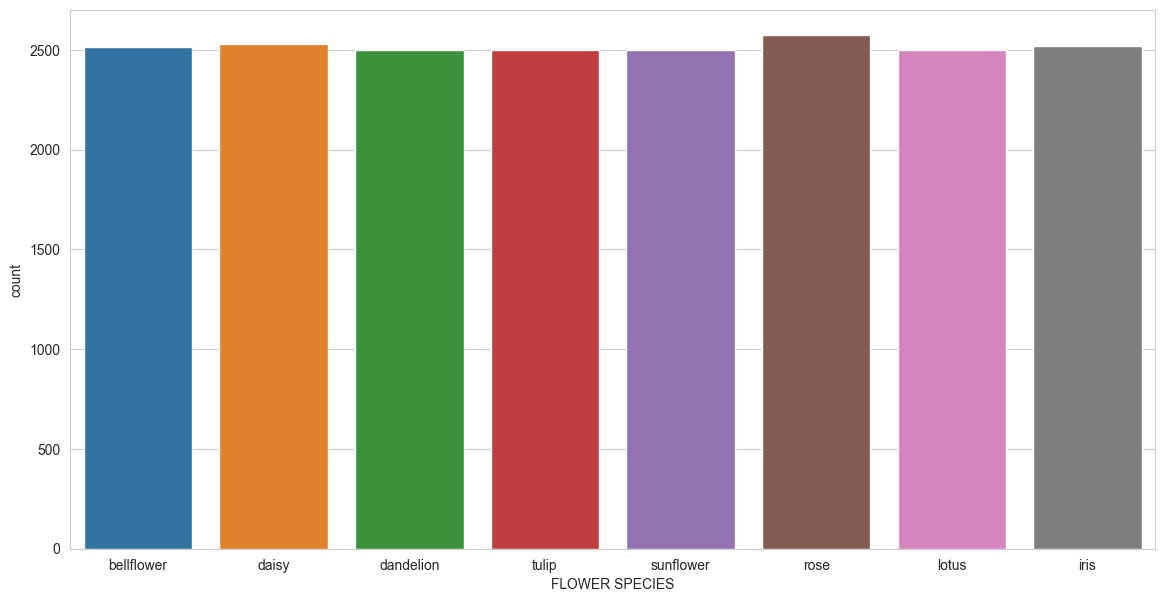

In [7]:
l = [labels[y] for y in y_list]
plt.figure(figsize=(14,7))
sns.set_style('whitegrid')
ax = sns.countplot(x=l)
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
plt.xlabel('FLOWER SPECIES')
plt.show()

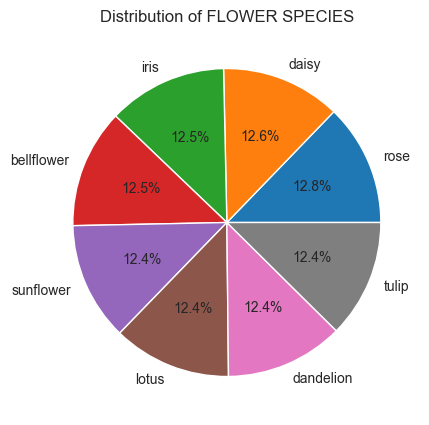

In [8]:
l = [labels[y] for y in y_list]
plt.figure(figsize=(7, 5))
counts = pd.Series(l).value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribution of FLOWER SPECIES')
plt.show()

In [9]:
x = np.asarray(x_list, dtype=np.float32)
y = np.asarray(y_list, dtype=np.float32)

for s in range(100):
    x, y = shuffle(x, y)

print("Shape of feature matrix X")
print(x.shape)
print("\nShape of label matrix Y")
print(y.shape)

class_types, counts = np.unique(y, return_counts=True)

print("\nClass labels")
print(class_types)
print("\nClass counts")
print(counts)

Shape of feature matrix X
(20137, 1000)

Shape of label matrix Y
(20137,)

Class labels
[0. 1. 2. 3. 4. 5. 6. 7.]

Class counts
[2513 2530 2500 2500 2501 2573 2501 2519]


In [10]:
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=40)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.125, stratify=y_train_temp, random_state=40)

print("Shape of train_X")
print(x_train.shape)
print("\nShape of test_X")
print(x_test.shape)

Shape of train_X
(14095, 1000)

Shape of test_X
(4028, 1000)


## CONFUSION MATRIX

In [11]:
class ConfusionMatrixPlot:
    def __init__(self, labels, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = labels
    def plot(self):
        conf_matrix = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred)
        plt.figure(figsize = (8,8))
        sns.heatmap(conf_matrix, annot=True, linecolor = 'black' , linewidth = 1, fmt='', cmap="Blues", xticklabels = self.labels , yticklabels = self.labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix Of Best Model')
        plt.show()

## CLASSIFICATION REPORT

In [12]:
class ClassificationReportPlot:
    def __init__(self,labels, true_labels, predicted_labels):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.labels = labels
    def plot(self):
        report = classification_report(self.true_labels, self.predicted_labels, target_names=labels, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        pd.set_option("display.max_rows", None)
        report_df.style.set_properties(**{'border-color': 'black', 'border-style': 'solid'})
        display(report_df)
        plt.show()

## K NEAREST NEIGHBOR

Best Model: KNeighborsClassifier(n_neighbors=9,
                     weights=<function weight2 at 0x000001B70F06EB90>)


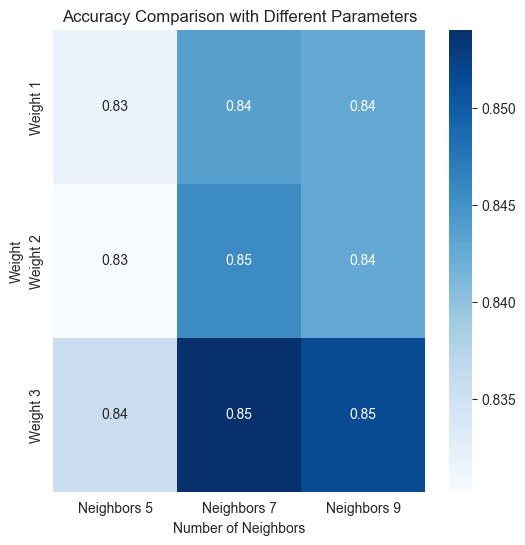

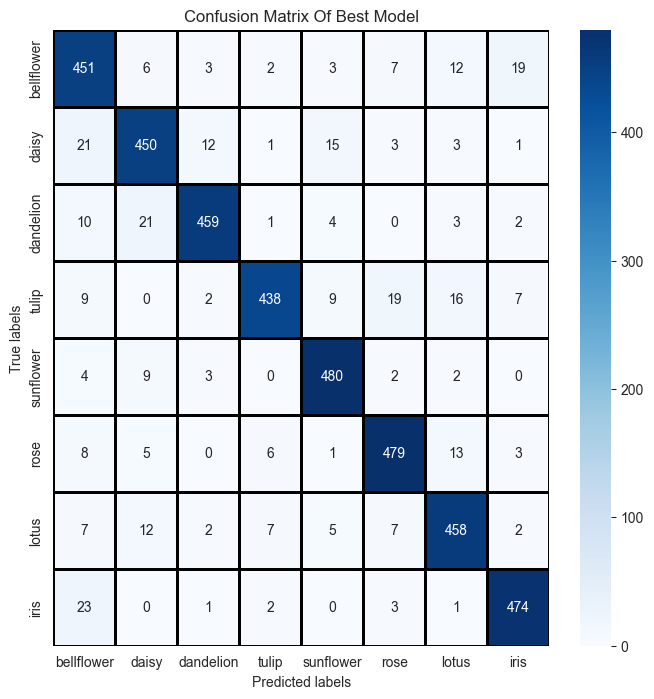

,precision,recall,f1-score,support
bellflower,0.846154,0.896620,0.870656,503.000000
daisy,0.894632,0.889328,0.891972,506.000000
dandelion,0.952282,0.918000,0.934827,500.000000
tulip,0.958425,0.876000,0.915361,500.000000
sunflower,0.928433,0.960000,0.943953,500.000000
rose,0.921154,0.930097,0.925604,515.000000
lotus,0.901575,0.916000,0.908730,500.000000
iris,0.933071,0.940476,0.936759,504.000000
accuracy,0.915839,0.915839,0.915839,0.915839
macro avg,0.916966,0.915815,0.915983,4028.000000


In [13]:
from sklearn.model_selection import GridSearchCV
def weight1(distances):
    return distances
def weight2(distances):
    return 1 / distances**2
def weight3(distances):
    return 1 / distances
param_grid = {
    'n_neighbors': [5, 7, 9],
    'weights': [weight1, weight2, weight3]
}
KNN = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=KNN, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(mean_test_scores.reshape(len(param_grid['weights']), len(param_grid['n_neighbors'])),
                    index=[f'Weight {i+1}' for i in range(len(param_grid['weights']))],
                    columns=[f'Neighbors {j}' for j in param_grid['n_neighbors']])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Number of Neighbors')
plt.ylabel('Weight')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

## SVM

In [14]:
from sklearn import svm
def gamma1():
    return 0.002
def gamma2():
    return 0.0005
def gamma3():
    return 0.001
param_grid = [
    {'C': [1,2,5], 'gamma': [gamma1, gamma2, gamma3]},
]
svm = svm.SVC(kernel='rbf')
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(
    np.array(mean_test_scores).reshape(len(param_grid['C']), len(param_grid['gamma'])),
    index=[f'C {i}' for i in param_grid['C']],
    columns=[f'gamma {j+1}' for j in range(len(param_grid['gamma']))])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'gamma' parameter of SVC must be a str among {'scale', 'auto'} or a float in the range [0.0, inf). Got <function gamma1 at 0x000001B74CE82440> instead.

--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'gamma' parameter of SVC must be a str among {'scale', 'auto'} or a float in the range [0.0, inf). Got <function gamma2 at 0x000001B74CE824D0> instead.

--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Nguyen Duc Thinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'gamma' parameter of SVC must be a str among {'scale', 'auto'} or a float in the range [0.0, inf). Got <function gamma3 at 0x000001B74CE82680> instead.


## XGBOOST


In [ ]:
param_grid = {
    'max_depth': [50,100,200],
    'n_estimators': [200,300,400]
}
XGBoost = XGBClassifier(random_state=50, n_jobs=-1)
grid_search = GridSearchCV(estimator=XGBoost, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(mean_test_scores.reshape(len(param_grid['max_depth']), len(param_grid['n_estimators'])),
                    index=[f'max_depth {i}' for i in param_grid['max_depth']],
                    columns=[f'n_estimators {j}' for j in param_grid['n_estimators']])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('N Estimator')
plt.ylabel('Max Depth')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


## RIDGE CLASSIFICATION

In [ ]:
param_grid = {
    'alphas': [0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
ridge_classifier = RidgeClassifierCV()
grid_search = GridSearchCV(estimator=ridge_classifier, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_train_temp,y_train_temp)
y_pred = best_model.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(
    np.array(mean_test_scores).reshape(len(param_grid['alphas']), len(param_grid['solver'])),
    index=[f'alphas {i+1}' for i in range(len(param_grid['solver']))],
    columns=[f'solver {j}' for j in param_grid['alphas']])
plt.figure(figsize=(7, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Alphas')
plt.ylabel('Solver')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()

## NEURAL NETWORK

In [ ]:
n_encoder = OneHotEncoder(sparse=False)
n_encoder.fit(y_train.reshape(-1,1))
e_train_Y = n_encoder.transform(y_train.reshape(-1,1))
e_test_Y = n_encoder.transform(y_test.reshape(-1,1))

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(256, input_dim=1000, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(8, kernel_regularizer=l2(0.1), activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
                 loss="categorical_hinge")
    return model

model1 = create_model()
model1.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               256256    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 258,312
Trainable params: 258,312
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 50
history = model1.fit(x_train, e_train_Y, validation_split = 0.15, epochs=epoch, batch_size=64, verbose=1)

In [ ]:
sea.set_style("darkgrid")
e = np.linspace(1, epoch, epoch)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
sea.lineplot(x = e, y = history.history["loss"],
             ax=axes, label="train"),
sea.lineplot(x = e, y = history.history["val_loss"],
             ax=axes, label="val"),
axes.set_ylabel("Categorical Hinge Loss")
axes.set_xlabel("epoch"),

In [ ]:
y_pred = model1.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
confusion_plot = ConfusionMatrixPlot(y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(y_test, y_pred)
report_plot.plot()

In [ ]:
#Chuyển mảng x thành mảng 2 chiều
 ## x_2d = np.reshape(x, (-1, 1))

# Tạo DataFrame từ mảng và label
## data = pd.DataFrame({'features': x_2d.ravel(), 'labels': y})

# Lưu DataFrame vào file CSV
## data.to_csv('processed_data.csv', index=False)


## COMPARE


In [ ]:
from matplotlib import pyplot as plt
plt.style.use('default')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

objects = ('KNN', 'Naive Bayes', 'Random Forest', 'ANN')
y_pos = np.arange(len(objects))
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['font.size'] = '20'

training_samples1 = [97.12,96.15,95.19, 98.08]
training_samples_2 = [97.12,97.12,96.15, 98.08]
training_samples_3 = [100.0,96.15,97.12, 98.08]

for index, value in enumerate(training_samples1):
    plt.text(index - 0.35, value + 0.6, str(value), fontsize=16)
for index, value in enumerate(training_samples_2):
    plt.text(index - 0.1, value + 0.6, str(value), fontsize=16)
for index, value in enumerate(training_samples_3):
    plt.text(index + 0.14, value + 0.6, str(value), fontsize=16)
    
# for index, value in enumerate(min_rewardVSs):
#     plt.text(index + 0.25, value + 0.1, str("{:.3f}".format(value)), fontsize=14)
#plt.bar(y_pos, performance, align='center', alpha=0.5)

print(training_samples1)
bars_sigmoid = plt.bar(y_pos - 0.24, training_samples1, 0.24, label = '50 training samples', color = 'pink')
plt.bar(y_pos, training_samples_2, 0.24, label = '110 training samples', color = 'firebrick')
bars_linear = plt.bar(y_pos + 0.24, training_samples_3, 0.24, label = '170 training samples', color = 'mediumaquamarine')

plt.xticks(y_pos, objects)
plt.ylim([0, 110])
patterns = ("o", "o", "o", "o")
for i, x in zip(bars_sigmoid,patterns):
      i.set_hatch(x)
patterns = ("\\", "\\", "\\", "\\")
for i, x in zip(bars_linear,patterns):
      i.set_hatch(x)
plt.legend(fontsize = 20, bbox_to_anchor =(1, 1.15), ncol = 3)
#plt.margins(0.1,0)
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.savefig('../pics/Test/test_supervised.svg', bbox_inches='tight')
plt.savefig('../pics/Test/test_supervised.pdf', bbox_inches='tight')
plt.show()
